<div align='center'>
    <h2>Controle Quântico Ótimo</h2>
    <h4>Utilização do Algoritmo Genético para obtenção dos valores de controle</h4>
</div>

<div align='justify'>
    <p>Para que haja um controle ótimo de uma partícula, supondo que esta esteja em um estado inicial, é necessário formas de controle suficientemente eficientes já que a particula é a função de onda da partícula é definida em função do tempo. Para que isso seja possível utiliza-se a eficiência do algoritmo genético que pode usar ou não utilizar-se do elitismo juntamente com o controle preditivo, MPC. </p>
    <p>Abaixo são revelados os parâmetros para esse experimento, do qual podem ser ajustados:</p>
</div>

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp
import cmath

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize
from random import randint, uniform, random

In [2]:
## CONSTANTES PARA O CONTROLADOR

# Considerações: constante de Planck verdadeira: 1, massa: 1

TEMPO_ANALISE = 10 
QUANTIDADE_PONTOS_AMOSTRAGEM = 1000
PASSO = TEMPO_ANALISE/QUANTIDADE_PONTOS_AMOSTRAGEM

MIN_HORIZONTE = 3 # Horizonte mínimo da análise
MAX_HORIZONTE = 40 # Horizonte máximo da análise

ONDA_DESEJADA = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]] # [[c1];[c2]] = [[0.707],[0.707]]

# Determinação dos valores de início e fim da análise
num = PASSO
contador = 0
while num < 1:
    num *= 10
    contador += 1

EXPOENTE = contador
INICIO_ANALISE = 0*10**(-EXPOENTE) # Tempo inicial da analise em um horizonte
FINAL_ANALISE = (1*10**(-EXPOENTE))+PASSO # Tempo final da analise em um horizonte

In [3]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 5

In [4]:
# Manipulação das matrizes, soma e subtração

def somar(A, B):
    C = []
    num_linhas_a = len(A)
    num_colunas_a = len(A[0])
    
    for i in range (num_linhas_a):
        linha = [0]*num_colunas_a
        C.append(linha)
        for j in range(num_colunas_a):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    num_linhas_a = len(A)
    num_colunas_a = len(A[0])
    
    for i in range (num_linhas_a):
        linha = [0]*num_colunas_a
        C.append(linha)
        for j in range(num_linhas_a):
            C[i][j] = A[i][j] - B[i][j]

    return C

<div align='justify'>
    <h4>Runge-Kutta de quarta ordem</h4>
    <p>Nos procedimentos com estados quânticos, é necessário utilizar-se da equação de Schrödinger com o o objetivo de avaliar o valor da função de onda com o tempo. Sabe-se que sua equação se dá pela função de onda relacionada com a posição e tempo, no entanto, utilizando a notação de Dirac, a posição se torna um atributo irrelevante para a análise já que analisaremos níveis. Portanto: </p>
</div>

$$\frac{\partial{\ket{\psi(t)}}}{\partial{t}} = -iH\ket{\psi(t)}$$


In [5]:
## psi' = -i * H * ket{psi}
def dpsi_dt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * ket{psi}

# Runge-Kutta de quarta ordem

def runge_kutta(onda, fator_runge_kutta, hamiltoniano, tempo_inicial = 0):
    
    # onda = [[c0],[c1]]
    
    k1 = dpsi_dt(tempo_inicial, onda, hamiltoniano)
    k2 = dpsi_dt(tempo_inicial + 0.5 * fator_runge_kutta, somar(onda, np.dot((0.5*fator_runge_kutta), k1)), hamiltoniano)
    k3 = dpsi_dt(tempo_inicial + 0.5 * fator_runge_kutta, somar(onda, np.dot((0.5*fator_runge_kutta), k2)), hamiltoniano)
    k4 = dpsi_dt(tempo_inicial + fator_runge_kutta, somar(onda, np.dot(fator_runge_kutta, k3)), hamiltoniano)
    
    ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
    
    A = somar(np.dot(2,k3), k4)
    B = somar(np.dot(2,k2), k1)
    C = somar(A, B)

    runge = somar(onda,np.dot((fator_runge_kutta / 6.0),(C)))
        
    return runge

<div align='justify'>
    <h4>Estabelecimento da função objetivo</h4>
    <p>O estudo se baseia em uma função de erro, da qual exije a comparação de um sistema de dois níveis em um certo tempo em relação ao seu desejado. Para que isso seja possível estabelece-se a noção de controle preditivo.</p>
    <p>O controle preditivo é um modelo que se utiliza da avaliação futura para reajustar uma curva em relação a sua referência, ou seja, esta família de controles tem a capacidade de visualizar instantes a frente para definir qual é a melhor rota. Com esse tipo de controle, a função objetivo estabelece-se da seguinte forma:</p>
</div>

$$\min ||\sum^{i+h}_{j = i} \ket{\psi(j)} - \ket{\psi_d(j)}||$$

In [6]:
def func_objetivo(x, it, onda_desejada, hamiltoniano, 
                  onda_inicial, horizonte, fator_runge_kutta):
    
    fo = 0
    runge = np.zeros((2,1),dtype=np.complex_)
        
    tempo = it   
    
    tempo_inicial = INICIO_ANALISE
    tempo_final = FINAL_ANALISE
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matriz_inicial = np.zeros((2,1),dtype=np.complex_)
    matriz_inicial = [[onda_inicial[0][0]], [onda_inicial[1][0]]] 

    matriz_desejada = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matriz_desejada[0][0] = onda_desejada[0][0]*np.exp(-1*complex(0,1)
                                                       *(1/2*np.pi)*tempo)
    matriz_desejada[1][0] = onda_desejada[1][0]*np.exp(-1*complex(0,1)
                                                       *(3/2*np.pi)*tempo)

    fo += (np.linalg.norm(matriz_inicial-matriz_desejada))**2

    runge = runge_kutta(matriz_inicial, fator_runge_kutta, 
                        somar(hamiltoniano, controles), 
                        tempo_inicial = tempo_inicial)

    matriz_inicial = runge

    tempo_inicial = round(tempo_inicial+PASSO, EXPOENTE)
    tempo_final = round(tempo_final+PASSO, EXPOENTE)
    tempo = round(tempo+PASSO, EXPOENTE)
    
    while horizonte > 1:
        
        matriz_desejada[0][0] = onda_desejada[0][0]*np.exp(-1*complex(0,1)
                                                           *(1/2*np.pi)*
                                                           tempo)
        matriz_desejada[1][0] = onda_desejada[1][0]*np.exp(
            -1*complex(0,1)*
            (3/2*np.pi)*tempo)
        
        fo += (np.linalg.norm(matriz_inicial-matriz_desejada))**2
        
        controles = [[0, x[len(x)-horizonte+1]], 
                     [x[len(x)-horizonte+1], 0]]

        runge = runge_kutta(matriz_inicial, fator_runge_kutta, somar
                            (hamiltoniano, controles), 
                            tempo_inicial = tempo_inicial)

        matriz_inicial = runge

        tempo_inicial = round(tempo_inicial+PASSO, EXPOENTE)
        tempo_final = round(tempo_final+PASSO, EXPOENTE)
        tempo = round(tempo+PASSO, EXPOENTE)
        horizonte -= 1
    
    return fo

<div align='justify'>
<p>Para o funcionamento do MPC, cria-se um looping de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.</p>
</div>

In [7]:
def vfo(valor):
    ts = np.linspace(0, TEMPO_ANALISE, QUANTIDADE_PONTOS_AMOSTRAGEM)

    plt.ylabel('Função Objetivo') 
    plt.xlabel('Tempo') 
    plt.plot(ts, abs(valor[0])/abs(valor[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Valor da FO")
    plt.legend(loc="upper right")
    plt.show()

In [8]:
def evolucao_desejada():
    evolucao_d = np.zeros((2,QUANTIDADE_PONTOS_AMOSTRAGEM), dtype=np.complex_)
    
    tempo = 0
    pos = 0
    while tempo < TEMPO_ANALISE:
        
        evolucao_d[0][pos] = (ONDA_DESEJADA[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo))
        evolucao_d[1][pos] = (ONDA_DESEJADA[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo))
    
        tempo = round(tempo+PASSO, EXPOENTE)
        pos += 1
        
    return evolucao_d

In [9]:
def plot_componentes(valores_onda, evolucao_d, componente):
    
    ts = np.linspace(0, TEMPO_ANALISE, QUANTIDADE_PONTOS_AMOSTRAGEM)
    
    real_inicial = [elemento.real for elemento in valores_onda[componente-1]]
    imaginario_inicial = [elemento.imag for elemento in valores_onda[componente-1]]
    
    real_desejado = [elemento.real for elemento in evolucao_d[componente-1]]
    imaginario_desejado = [elemento.imag for elemento in evolucao_d[componente-1]]
    
    # Plotagem
    plt.subplot(2,1,1)

    plt.ylabel('Pesos') 
    plt.xlabel('Tempo') 
    plt.title(f"{componente}ª componente -> real")
    plt.plot(ts, real_inicial, color='r', marker='*', linewidth=1, markersize=1, label="Inicial")
    plt.plot(ts, real_desejado, color='b', marker='o',  linewidth=1, markersize=1, label="Desejado")
    plt.legend(loc='upper right')
    
    plt.subplot(2,1,2)

    plt.ylabel('Imaginário') 
    plt.xlabel('Tempo') 
    plt.title(f"{componente}ª componente -> imaginária")
    plt.plot(ts, imaginario_inicial, color='r', marker='*', linewidth=1, markersize=1, label="Inicial")
    plt.plot(ts, imaginario_desejado, color='b', marker='o',  linewidth=1, markersize=1, label="Desejado")
    plt.legend(loc='upper right')

    plt.tight_layout()

<div align='justify'>
    <h4>Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x</h4>
    <p> Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:</p>
</div>

$$\int |\Psi(x,t)|^{2}dx = 1$$ 

<div align='justify'>
    <p>Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados:</p>
</div>

$$0,80\psi_0(x,t)+0,60\psi_1(x,t)$$

<div align='justify'>
    <p>de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.</p>
</div>

In [10]:
def probabilidade(constantes):
    
    ts = np.linspace(0, TEMPO_ANALISE, QUANTIDADE_PONTOS_AMOSTRAGEM)
    
    dp = []
    for i in range(0, QUANTIDADE_PONTOS_AMOSTRAGEM):
        dp.append((abs(constantes[0][i])**2+abs(constantes[1][i])**2))

    plt.ylabel('Densidade probabilidade') 
    plt.xlabel('Tempo') 
    plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
    plt.legend(loc="upper right")
    plt.show()

<div align='justify'>
    <h4>Programa principal</h4>
    <p>O programa principal utiliza a onda inicial e o horizonte desejado para encontrar o melhor valor para controladores por meio de um laço que chama, a todo momento, as funções observadas acima.</p>
</div>

In [11]:
from scipy.optimize import differential_evolution

def main(horizonte, onda_inicial):
    
    u = [] # Controladores iniciais
    u.append(uniform(-1,1))
    while len(u) < horizonte:
        u.append(u[0])
        
    # O que será retornado por essa função
    
    vetor_controles = np.zeros((1, QUANTIDADE_PONTOS_AMOSTRAGEM), dtype=np.complex_) # Valores de controle
    valores_funcao_objetivo = np.zeros((1, QUANTIDADE_PONTOS_AMOSTRAGEM), dtype=np.complex_) # Utilização do controle para comparação com o valor esperado
    constantes = np.zeros((2, QUANTIDADE_PONTOS_AMOSTRAGEM), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
    valores_onda = np.zeros((2, QUANTIDADE_PONTOS_AMOSTRAGEM), dtype=np.complex_)
    
    hamiltoniano = np.zeros((2,2), dtype=np.complex_)
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    tempo = 0
    pos = 0
    while tempo < TEMPO_ANALISE:

        if (pos%10 == 0):
            print(f"Iteração: {pos+1}")
        
        # Variação do Psi
        valores_onda[0][pos] = onda_inicial[0][0]
        valores_onda[1][pos] = onda_inicial[1][0]
        
        # Obtenção das constantes que multiplicam Psi
        # C_0 = Psi_0/[e^(1/2*pi*tempo)] equação 2.18 Griffiths
        constantes[0][pos] = onda_inicial[0][0]/np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        constantes[1][pos] = onda_inicial[1][0]/np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        ## Minimização
        bounds = [(-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), 
                  (-5, 5), (-5, 5), (-5, 5), (-5, 5)]
        resultado = differential_evolution(func_objetivo, 
                                           bounds, 
                                           args=(tempo, ONDA_DESEJADA, hamiltoniano, 
                                                 onda_inicial, horizonte, PASSO))        
        # Função objetivo

        print(resultado.x)
        vetor_controles[0][pos] = resultado.x[0]

        valores_funcao_objetivo[0][pos] = func_objetivo(resultado.x, tempo, ONDA_DESEJADA, hamiltoniano, onda_inicial, horizonte, PASSO)
        
        controle = np.zeros((2,1), dtype=np.complex_)
        controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
        hamiltoniano = somar(hamiltoniano, controle)

        ## Adaptação da onda ao controle

        onda_avancada = np.zeros((2,2), dtype=np.complex_)
        onda_avancada = runge_kutta(onda_inicial, PASSO, hamiltoniano, tempo_inicial = INICIO_ANALISE)

        onda_inicial[0][0] = onda_avancada[0][0]
        onda_inicial[1][0] = onda_avancada[1][0]

        # Reset
        hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

        u = [] # Controladores iniciais
        u.append(uniform(-1,1))
        while len(u) < horizonte:
            u.append(u[0])
        
        pos += 1
        tempo = round(tempo+PASSO, EXPOENTE)
    
    return vetor_controles, valores_funcao_objetivo, constantes, valores_onda
    

<div align='justify'>
    <h4>Variação dos horizontes</h4>
    <p>Como será observado a frente, a variação dos horizontes auxiliam na melhoria da defasagem apresentada pelo sistema, no entanto isso gera complicações no custo computacional.</p>
</div>

In [12]:
desejo = evolucao_desejada()

ondaInicial = [[complex(0.8,0.0)],[complex(0.6,0.0)]]

vetor_controles, valores_funcao_objetivo, constantes, valores_onda = main(10, ondaInicial)

Iteração: 1
[-3.27830391  0.90095821  0.91531238  0.87139234  0.85845567  0.82470534
  0.90234044  0.87668923  0.86017971 -2.27463517]
[ 0.51026096  0.87425062  0.86319305  0.87525194  0.83485348  0.91989171
  0.84618381  0.83934885  0.85343692 -3.14477466]
[ 0.45916271  0.86254413  0.89419091  0.84546333  0.88367949  0.83257152
  0.83368194  0.84866251  0.87642702 -3.50527669]
[ 0.47719295  0.84579452  0.89462928  0.7942463   0.8574236   0.89907498
  0.84175555  0.82209006  0.83348593 -2.16890659]
[0.4344744  0.87909607 0.86998865 0.81098324 0.85038558 0.85328544
 0.85365208 0.82569429 0.82116387 0.05555026]
[5.22347725e-01 7.91735006e-01 8.76817709e-01 7.96206463e-01
 8.68246126e-01 8.46053000e-01 8.05450930e-01 8.83933219e-01
 7.55376286e-01 2.12903763e-04]
[ 0.41301879  0.82006573  0.86112834  0.83534926  0.85330079  0.77605446
  0.85211397  0.82699771  0.82549442 -3.12108277]
[ 0.44780775  0.8462499   0.83391651  0.82961685  0.81259558  0.81248349
  0.81680213  0.81321597  0.81478

[ 0.20389881  0.45722978  0.51307316  0.51139006  0.46254334  0.46732101
  0.47226079  0.52069405  0.41730179 -3.09571046]
Iteração: 71
[ 0.28606598  0.49203903  0.48078124  0.42714438  0.48266946  0.48984547
  0.49200652  0.43219997  0.47528944 -0.88921675]
[0.26024395 0.48415771 0.42485124 0.49684412 0.49511085 0.46282795
 0.42182848 0.49881721 0.44387775 2.8830117 ]
[ 0.22039318  0.48568021  0.53059123  0.36366294  0.53234591  0.4648103
  0.4424002   0.42987867  0.53194949 -3.45220731]
[ 0.28273307  0.4797218   0.43098829  0.47658718  0.48566958  0.43579582
  0.47833618  0.44109789  0.44417527 -1.47176554]
[0.26185344 0.44191587 0.45736002 0.43904743 0.51947893 0.41243725
 0.45794521 0.46024501 0.48947825 1.32827517]
[ 0.20355463  0.50493426  0.44597395  0.44588609  0.44565654  0.46472775
  0.45702612  0.44421748  0.42874537 -1.01428846]
[ 0.3188895   0.44678423  0.39876011  0.47131277  0.44393841  0.47789745
  0.41221861  0.46526715  0.4213766  -0.08886996]
[ 0.20256517  0.4503565 

[0.09381798 0.32929273 0.18560096 0.24193338 0.28976804 0.23626054
 0.2549191  0.29548733 0.21766143 0.7089306 ]
[ 0.15636776  0.2608467   0.27585996  0.21242434  0.28339954  0.22315663
  0.27811378  0.2107222   0.27321225 -2.03080825]
Iteração: 141
[ 0.13060287  0.26331634  0.25984233  0.23443261  0.25857784  0.24139812
  0.25677117  0.24458751  0.23435248 -3.04646499]
[0.16094461 0.22446339 0.2782065  0.22779901 0.24345475 0.25951168
 0.23737719 0.26889236 0.18576162 3.29887879]
[ 0.11796257  0.27876497  0.21324159  0.26127413  0.22543066  0.29945611
  0.1717658   0.2557723   0.25163211 -2.7032024 ]
[0.13439296 0.24536208 0.23600204 0.25200601 0.26803905 0.19733534
 0.25004777 0.23145759 0.28353056 2.09258267]
[ 0.11469878  0.26184769  0.25168341  0.24892618  0.20668153  0.25614214
  0.24197602  0.21580157  0.23601443 -3.9743235 ]
[ 0.15188274  0.23699023  0.24797116  0.22347413  0.24453871  0.24574569
  0.24189627  0.2243598   0.23888737 -4.44997647]
[0.14089851 0.19123844 0.2947740

[ 0.05661892  0.1176123   0.0883974   0.18695225  0.12584418  0.11850964
  0.11961939  0.16537036  0.09976853 -0.43135043]
[0.03907428 0.125059   0.15636365 0.12649159 0.16298727 0.07393676
 0.14957185 0.10384485 0.17444465 0.98443063]
Iteração: 211
[0.08704795 0.17575488 0.05770843 0.12841239 0.20589025 0.08228266
 0.16315549 0.07275695 0.12320369 0.47023316]
[ 0.06640555  0.14138495  0.10622093  0.12786184  0.13799926  0.12862337
  0.1391981   0.10213787  0.16168332 -2.6575382 ]
[ 0.04780373  0.16086901  0.07585588  0.20078126  0.09219053  0.18772768
  0.01541859  0.17993643  0.15926167 -3.78789337]
[ 0.06622677  0.15081917  0.15146104  0.08728009  0.14417015  0.13017981
  0.15519557  0.09562085  0.09826064 -0.07748227]
[0.07626666 0.13985765 0.12489658 0.13831355 0.10110839 0.17498124
 0.09241282 0.13023818 0.11317198 0.38921388]
[0.12474707 0.08935824 0.12430062 0.10062289 0.16100361 0.09560481
 0.18250867 0.08447873 0.09608752 1.50643362]
[ 0.03427841  0.06972546  0.18303833  0.10

[0.03786669 0.02762602 0.16604735 0.03243456 0.07878488 0.00722116
 0.0847532  0.07540362 0.10692203 1.7425914 ]
[ 0.03953656  0.07387683  0.05007029  0.09016855  0.10445126  0.00766642
  0.08618633  0.03078951  0.12921133 -3.99547844]
[ 0.06189001  0.04036321  0.10398852 -0.01664315  0.14679356  0.06586194
  0.04199286  0.04903267  0.09133255  1.74438827]
Iteração: 281
[0.01783376 0.05583611 0.08275455 0.07562618 0.06978708 0.03218852
 0.08505157 0.05211342 0.07292512 1.91160402]
[ 0.06256266  0.04158688  0.0418955   0.09209781  0.06255434  0.09362142
  0.0222102   0.09018467  0.03080194 -3.30138282]
[-0.00729385  0.12433816 -0.01792936  0.0926765   0.06261574  0.1158283
  0.01953766  0.10456477  0.04127106 -3.48312306]
[ 0.06035961  0.05820147  0.04521746  0.09480412  0.06831892  0.03415031
  0.10164406  0.05398186  0.06021752 -2.54723205]
[0.02836454 0.03210148 0.10437847 0.05727178 0.07250331 0.04446266
 0.07056871 0.06242299 0.09295857 0.75097818]
[ 0.04068757  0.06880742  0.04904

[ 0.04431755  0.00999549  0.12397488 -0.02676585  0.06701528  0.00866021
  0.05917594  0.04255216  0.00970981 -0.14734506]
[ 0.07664509 -0.03220249  0.06073305  0.02677095  0.0506853   0.03232245
  0.03501821  0.02147815  0.06581357 -4.37600985]
[-0.00062254  0.03307211  0.01713649  0.02209453  0.03963681  0.01644018
  0.10555281  0.0060111   0.01622737 -0.10471688]
[-0.020975   -0.00645786  0.1669049  -0.05051537  0.08556611 -0.02163317
  0.04861383 -0.00435807  0.13042314 -0.56949397]
[ 0.03364659  0.03039325  0.04054658  0.05051064  0.03706939  0.02759036
  0.03619174  0.03547751  0.03307837 -1.38872875]
[ 0.00994489  0.07822763 -0.00599392  0.09781884 -0.00894823  0.01857745
  0.05501574 -0.02389556  0.10351655  0.11024037]
[ 0.02732078  0.03935536  0.03909065  0.02983933  0.04630343  0.03033628
  0.0282064   0.03481185  0.04224501 -2.85384051]
[-0.00616587  0.07539425  0.03374997  0.06037024 -0.01982469  0.03828961
  0.05882471  0.03982893  0.02404121 -0.66863182]
Iteração: 351
[0

[ 0.01848932  0.0071054   0.01843833  0.01922378  0.02244221  0.02636515
  0.02495165  0.00868938  0.02367178 -0.20356206]
[1.14634585e-03 2.80369347e-02 2.02637566e-02 2.51460573e-03
 5.32153444e-02 1.33760755e-02 1.82751344e-03 1.91022142e-02
 3.62996842e-02 3.96771759e+00]
[ 0.05562195 -0.00970478  0.01205159 -0.03461716  0.10753114 -0.01897537
 -0.02086702  0.07109067  0.03502631  0.66158881]
Iteração: 411
[-0.02773368 -0.00316835  0.05151117  0.01515896  0.01106998  0.00169143
  0.05168079  0.01738206 -0.00196494  0.33883623]
[ 3.14768482e-02 -6.94973021e-03  1.37850381e-02  1.50298914e-02
  7.53369786e-02 -5.81536025e-02  5.61213957e-02 -9.26385872e-04
  5.45958123e-02  2.09209429e+00]
[-1.41565910e-02  1.79544138e-02  3.12866291e-03  2.24483654e-02
  4.91804153e-02  1.42064338e-02  1.79557973e-02  3.73290969e-03
  4.88879151e-02 -4.35921830e+00]
[ 0.01042593  0.04105875 -0.02142899  0.05229268 -0.01204353  0.050254
  0.02293135 -0.00152444 -0.00846737  0.0521137 ]
[ 1.67249150e-

[-1.25579892e-02  1.10937950e-02  3.36628880e-02 -4.50888383e-04
  9.22438982e-03  2.60243316e-02 -3.01807551e-03  1.92036167e-02
 -2.27138773e-03  4.13362258e+00]
[-0.02274031  0.04780862  0.01336054  0.01089775  0.02270616 -0.00535117
  0.03309704 -0.01083676  0.07140474 -2.52509902]
[ 0.03679547 -0.02913122  0.11559827 -0.03672764  0.01848429 -0.03701412
  0.07458386 -0.03149589  0.01702491  3.11395612]
[ 0.0437925  -0.00538859 -0.03023338  0.04609096 -0.00863289  0.04266194
 -0.00528826  0.01970398 -0.00991421 -1.50591682]
Iteração: 471
[ 8.11621487e-03 -1.16613323e-02 -4.73388772e-03 -1.63088659e-02
  6.53543660e-02 -1.34841270e-04 -1.34190607e-02  4.18573115e-02
 -6.15961112e-03 -2.89881283e+00]
[-0.05360748  0.04050667  0.01794482  0.01960722  0.00373327  0.02512181
 -0.00507478  0.01679737 -0.00723182 -2.76754884]
[ 0.05931241 -0.03712823  0.0178525   0.02793686  0.05281148 -0.0315524
 -0.00453107  0.02687121  0.01879605 -2.27135466]
[-0.02816383  0.03569607 -0.00742379  0.0226

[ 1.96147792e-02 -7.76345077e-03  2.13408446e-02 -4.35359634e-03
  1.08288763e-02  2.02869267e-02 -1.31181156e-02  4.18552343e-04
  1.62092078e-03 -4.05024655e+00]
[-2.23530120e-02  2.52906189e-02  1.47599969e-03  1.29635690e-02
  4.41994512e-03  6.59377335e-03  6.96111758e-04  2.02096788e-02
 -1.20320582e-02 -1.90615087e+00]
[-0.00248101  0.03471855 -0.00483137  0.0573402  -0.05893002 -0.01180844
  0.04184052  0.01616936  0.02436242 -0.8071174 ]
[ 0.01348972  0.00492092  0.05713719 -0.02444188  0.01756126 -0.01195966
  0.00343755 -0.005397    0.01372459  1.29432014]
[ 0.03019941  0.0108965  -0.04306094  0.03019255  0.00860267  0.009349
  0.01175478  0.00519614  0.01904048  0.90944036]
[-6.12022759e-03 -1.30998729e-03  1.39314180e-02  2.82439682e-03
  7.45624740e-03  5.96109437e-04  1.61740469e-02 -5.30768962e-03
  1.41479833e-02 -3.40511294e+00]
[-0.01581581  0.04171514 -0.01010951 -0.01115563  0.01645104 -0.01609347
  0.09942117 -0.0644543  -0.01133913 -0.75320455]
Iteração: 531
[ 0.

[ 2.83432635e-02 -4.03758832e-02  5.03509170e-02 -1.45113754e-02
 -4.78220547e-02  5.76826689e-02  1.11045354e-02  3.24892763e-03
 -2.49338126e-02 -3.31023358e+00]
[-3.15249905e-03  1.25793279e-02 -5.69919639e-02  4.83808415e-02
 -2.35953628e-02  5.81031238e-02 -3.10270707e-02  5.11082959e-03
  6.77137689e-03  3.24846000e+00]
[ 4.17416326e-03 -3.03058443e-02  2.05348949e-02  3.67452412e-02
 -2.39747506e-02  1.61877484e-02 -2.86106867e-02 -1.50244441e-02
  7.45913425e-02  4.99697018e+00]
[-0.01804084  0.0115027   0.01233478 -0.01113292  0.00849521 -0.0362021
  0.06425185 -0.02000895 -0.00433096 -2.79925468]
[ 2.66918567e-02 -1.06033583e-03 -8.87676458e-03 -3.84153103e-02
  7.34382736e-02 -4.06553996e-02  3.88084984e-02 -3.11373853e-02
  3.16545575e-02 -2.62606353e+00]
[-3.86573595e-03 -7.90120946e-03 -1.54807010e-03  1.04711004e-03
 -8.86700517e-04  7.90959139e-03  4.06086134e-04  1.82445781e-02
  2.51210134e-02  4.42587850e+00]
[-0.02207667  0.00690798  0.01329642  0.00789315  0.000280

[ 3.02614490e-03  1.61670184e-02  2.93502007e-03 -1.56952167e-03
  3.91431729e-03  1.64501812e-03 -2.00049438e-04 -1.00519942e-02
  1.61484062e-02  1.76881807e+00]
[-4.44179377e-03  1.98545964e-02  2.23598672e-03 -4.34706886e-04
  1.09891093e-02  1.43959474e-02 -8.89020484e-03 -1.08683607e-02
 -1.74058095e-03  2.52094955e+00]
[-0.01779275  0.05806231  0.02785968 -0.04696515  0.00956307 -0.08075526
  0.10401892 -0.0331747   0.02218259  1.78679445]
[-0.00320813  0.04046434 -0.00787996  0.01471603 -0.00459673  0.00933923
  0.01944828 -0.01442749 -0.0079253   2.68322646]
[ 0.06288406  0.01575854 -0.06445805  0.01458194  0.01145954 -0.00315592
  0.04112995 -0.05514457  0.05989546 -0.43173055]
[-0.0387727   0.03994726 -0.00615746  0.00530482 -0.04518485  0.03096684
 -0.00189757  0.0169366  -0.02223956  1.46230544]
[ 1.79765486e-02 -1.21140878e-04 -3.82828311e-03  3.93449491e-03
  1.67792832e-02 -1.60799941e-03 -2.74330847e-03 -9.19625149e-03
  1.90227413e-02 -7.20960973e-01]
[ 2.90912622e-03

[ 0.0302135   0.01750311 -0.05754967  0.04571263  0.02089583 -0.03979784
 -0.00355661 -0.0060011   0.05829401  2.37675457]
Iteração: 701
[-0.02405455  0.0682127  -0.04864677 -0.00405714 -0.03405423  0.04264476
 -0.05503947  0.07309952  0.00910649  0.64333445]
[ 0.02000196 -0.05293578  0.03232247  0.00152725  0.07205774 -0.0767496
  0.05617766 -0.02539818 -0.01374345  0.32073814]
[-0.0028119  -0.00184397  0.00836168  0.01061739  0.01107541 -0.04778265
  0.02990404 -0.02018557  0.03656565  0.6454096 ]
[ 1.30679865e-02 -2.86494374e-02  1.12332663e-02  9.71813886e-03
 -7.95381313e-04 -3.20203163e-03 -7.69051853e-03  6.95716453e-03
  1.06538312e-02 -1.05769366e+00]
[-0.01350256 -0.00152174 -0.00542545  0.03568176 -0.04439362  0.01886721
 -0.00596188  0.02421635 -0.03283629  1.15520654]
[-0.02315737  0.03429024 -0.02250692  0.0228019  -0.03135212  0.06050639
 -0.03771994  0.01432689 -0.00164678 -1.21419092]
[ 1.67761231e-02  1.45777697e-02 -1.49447824e-02  2.38604754e-02
 -2.82806486e-02  1.

[-0.0329441   0.06085479 -0.01507894  0.01537551 -0.02999782 -0.03690529
  0.0759788  -0.04758037  0.0161075  -1.38710663]
[ 5.03042112e-02 -9.80780977e-03 -1.23093580e-02 -1.12342230e-03
  2.53401086e-02 -8.36260765e-03 -1.09946185e-02 -6.14123172e-03
  1.96491199e-02 -4.82259447e+00]
[-0.01586269 -0.00389648 -0.00514339  0.00342251  0.00605742 -0.00341554
 -0.00282341  0.00575106  0.00687025  0.4816057 ]
[-1.31676394e-02  4.29305240e-03  1.48382092e-02 -1.04657852e-02
  1.25167129e-02 -1.31680272e-02  3.21816260e-02 -2.44602343e-02
 -3.35077336e-04  3.76890280e+00]
Iteração: 761
[ 0.01018369  0.00126269  0.00978491 -0.01591133  0.00965079  0.00551661
  0.00362539 -0.01951728  0.00685856  0.40078411]
[ 4.15297022e-05  9.67083107e-03 -1.14718441e-02  1.03163369e-02
 -7.86648392e-03  4.01138866e-02 -6.96172306e-02  2.31669699e-02
  3.25525922e-02 -3.22618873e+00]
[ 2.28699166e-02 -1.61149506e-03 -2.84776092e-02  1.20962180e-02
 -3.27905087e-02  3.26740643e-02 -3.55076699e-03  1.53260556

[-2.69612926e-03  5.91221651e-03 -1.07181147e-02  5.92021670e-03
 -2.97190903e-02  3.33075954e-02  1.93291812e-03 -1.93719415e-02
  1.00214268e-02  3.32584022e+00]
[-4.58587423e-03  2.15215649e-02 -2.43544416e-02  2.12686491e-03
  1.13067295e-03  2.12185222e-02 -3.17707335e-02 -4.89535230e-03
  2.05151383e-02  3.38603283e+00]
[-1.72426235e-02 -4.36975440e-03  2.51409216e-02 -4.44199970e-03
  3.68848206e-02 -3.18960640e-02 -1.45308118e-02 -2.68371823e-03
  1.82251394e-02 -2.96728148e+00]
[-2.03421209e-02  3.15063400e-02 -2.59324021e-03  5.62085971e-02
 -6.34320400e-02  1.84173714e-02 -4.15633701e-02  3.12200802e-02
  8.16379812e-03  3.76902636e+00]
Iteração: 821
[ 0.06219412 -0.0095107  -0.00317449 -0.00455347 -0.03558163  0.03806795
 -0.07377826  0.10739716 -0.04621808 -0.70391855]
[-0.04026078  0.01351119  0.01213585 -0.01678162  0.01581398 -0.04013892
  0.04291286 -0.02173955  0.0100009  -0.29822792]
[ 2.64454504e-02  5.70679695e-03 -4.65134406e-02  1.59356612e-02
 -9.92960802e-03 -6

[-3.25176248e-02  9.77611367e-03  2.04817202e-02 -1.86306001e-03
 -2.91698730e-02  2.82586194e-02 -1.14911391e-02  2.84054699e-02
 -1.80507215e-02  3.51664100e+00]
[ 0.06228991 -0.06627848  0.01330233  0.00588714  0.01548893 -0.025132
 -0.00116427  0.03156309 -0.02999385 -0.77198731]
[-0.08419071  0.03392868  0.01424305  0.02378245 -0.05086503  0.037667
 -0.00782915  0.00220749 -0.04098621 -1.70990027]
[ 4.99272133e-02 -1.07014853e-02 -2.02269660e-02  3.35834422e-02
  8.12817573e-03 -4.70518297e-03 -1.27241988e-03 -5.27808314e-02
  3.16390051e-02 -4.69028643e+00]
[-1.06892558e-02  2.19019377e-02 -1.67420348e-02 -2.12429725e-03
 -3.67173084e-03  1.95316869e-02 -2.21893917e-02 -3.86350801e-03
 -1.62241821e-02  2.79361243e+00]
[ 1.11004572e-02 -2.70779622e-02  2.69740297e-02 -9.60048314e-03
  2.19998810e-02 -5.02490482e-02  2.11951005e-02 -1.36980222e-03
  1.29035411e-02  1.85455452e+00]
Iteração: 881
[ 0.00672863 -0.02771495  0.05400987 -0.09751694  0.04747686  0.01232313
  0.04387523 -0

[-5.52293969e-02  6.91311862e-02 -8.61833957e-03  4.25938852e-02
 -7.20414995e-02  2.60261322e-02 -1.17231575e-02  6.28309318e-03
 -3.72170631e-03 -4.46316139e+00]
[ 0.04204589 -0.00312365  0.03236686 -0.00679843 -0.01335184 -0.01676552
  0.06599948 -0.05001937  0.0077657   0.59456647]
[ 2.50440190e-02 -1.37947484e-02  5.11236052e-03 -9.06225201e-03
  3.44085728e-02 -2.56455161e-02 -3.12769016e-03 -1.78101594e-02
  1.56921787e-04  2.33021043e+00]
[-0.00765777 -0.00970368 -0.00133615  0.0087954  -0.01047418  0.01308121
 -0.00904315 -0.00159125  0.00603113  0.03644451]
[ 7.27929890e-03  6.38745183e-04 -4.77672333e-03  2.98940319e-03
 -5.55237848e-02  4.06051261e-02  6.33344367e-03 -1.19065348e-03
  5.69359787e-03  3.26265011e+00]
[-0.06882204  0.12163596 -0.11333647  0.02445981  0.01940061  0.04674921
 -0.04432095  0.047244   -0.09226882 -2.79089353]
[ 5.43825551e-02  8.04455532e-03 -8.68782849e-03  6.57030378e-03
 -1.82911588e-03  4.75707916e-03 -1.35744722e-02  2.68059021e-03
  4.43408

[ 1.93193131e-02  7.99608567e-03 -5.92677899e-02  6.65992144e-02
 -2.51959941e-02  2.77442087e-02  9.51113026e-05 -5.73296788e-02
  2.01531622e-02 -1.07609008e+00]
[-0.01032401 -0.00626067  0.03010812 -0.01866956 -0.00840998  0.00310752
  0.00669783  0.00648908 -0.02762358  0.4999653 ]
[ 3.58723270e-02 -1.31177345e-02  9.58659381e-04 -7.17218229e-02
  9.16579345e-02 -6.49308884e-02  7.62719720e-02 -6.75877975e-02
 -1.28967079e-02  2.63657433e+00]
[-0.04608529  0.04093602 -0.0110874  -0.01305489 -0.00410205 -0.01277184
  0.02411222  0.00560213 -0.01471858  2.32522529]
[ 2.76154325e-02 -2.56365253e-03 -2.23262215e-02 -2.01587867e-04
  2.36244230e-02 -1.19308799e-02  8.93987162e-03 -1.59092145e-02
  4.44202375e-03  3.06408006e-01]
[ 0.01156197 -0.01126791 -0.01989758  0.01439587 -0.00862255 -0.01340057
 -0.00755554  0.03738436 -0.03112155 -1.38205886]
[-0.02172512  0.01470637 -0.00310726  0.0035964  -0.04041475  0.01651355
 -0.00320481  0.02592581 -0.02294582 -1.61608278]
[-0.02709807  0.

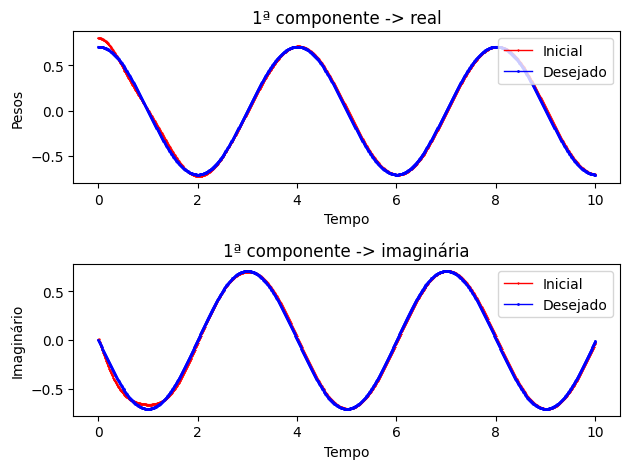

In [13]:
plot_componentes(valores_onda, desejo, 1)

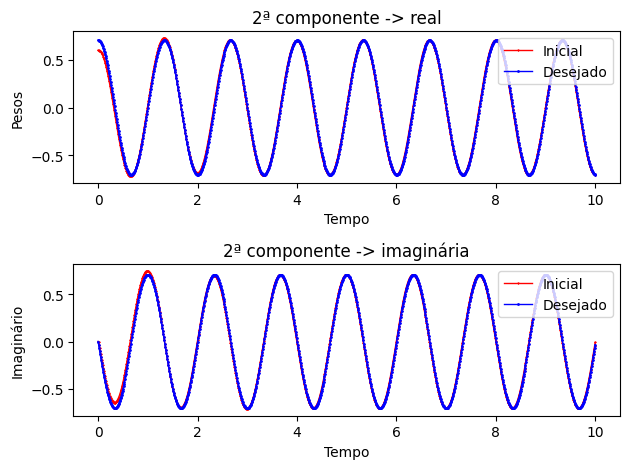

In [14]:
plot_componentes(valores_onda, desejo, 2)

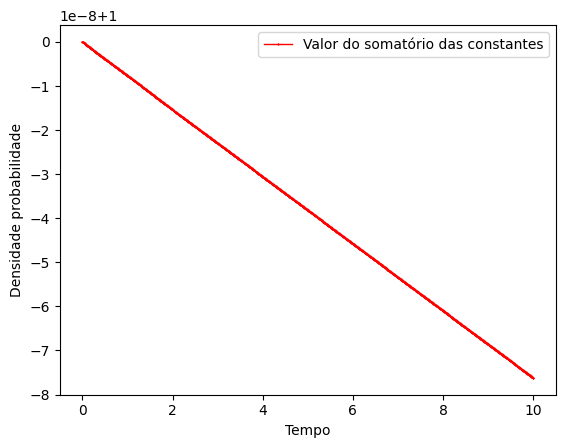

In [15]:
probabilidade(constantes)

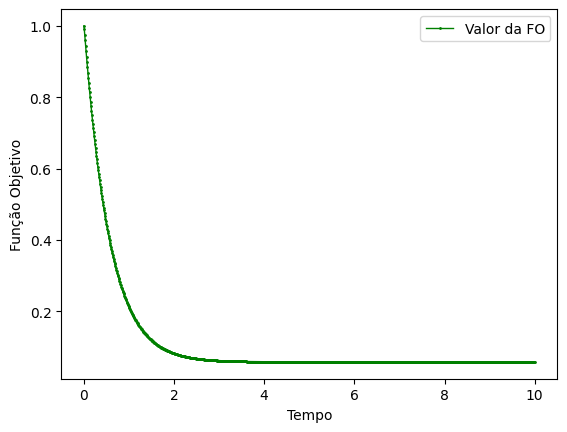

In [16]:
vfo(valores_funcao_objetivo)